<a href="https://colab.research.google.com/github/manusmriti31/Learning_PyTorch/blob/main/Exercise/06_pytorch_transfer_learning_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 06. PyTorch Transfer Learning Exercises

Welcome to the 06. PyTorch Transfer Learning exercise template notebook.

There are several questions in this notebook and it's your goal to answer them by writing Python and PyTorch code.

> **Note:** There may be more than one solution to each of the exercises, don't worry too much about the *exact* right answer. Try to write some code that works first and then improve it if you can.

## Resources and solutions

* These exercises/solutions are based on [section 06. PyTorch Transfer Learning](https://www.learnpytorch.io/06_pytorch_transfer_learning/) of the Learn PyTorch for Deep Learning course by Zero to Mastery.

**Solutions:**

Try to complete the code below *before* looking at these.

* See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/ueLolShyFqs).
* See an example [solutions notebook for these exercises on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/solutions/06_pytorch_transfer_learning_exercise_solutions.ipynb).

## 1. Make predictions on the entire test dataset and plot a confusion matrix for the results of our model compared to the truth labels.
* **Note:** You will need to get the dataset and the trained model/retrain the model from notebook 06 to perform predictions.
* Check out [03. PyTorch Computer Vision section 10](https://www.learnpytorch.io/03_pytorch_computer_vision/#10-making-a-confusion-matrix-for-further-prediction-evaluation) for ideas.

In [ ]:
# Import the necessary libraries
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms, datasets

# Importing torch info
try:
  from torchinfo import summary
except:
  print("[INFO] Coudn't find torchinfo... installing it")
  !pip install torchinfo
  from torchinfo import summary

# Importing the going modular section from githubm
try:
  from going_modular.going_modular import data_setup, engine, predictions
except:
  # Get the going_modular scripts
  print("[INFO] Couldn't find going_modular scripts downloading it...")
  !git clone https://github.com/mrdbourke/pytorch-deep-learning
  !mv pytorch-deep-learning/going_modular .
  !rm -rf pytorch-deep-learning
  from going_modular.going_modular import data_setup, engine

[INFO] Coudn't find torchinfo... installing it
[INFO] Couldn't find going_modular scripts downloading it...
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4393, done.
remote: Counting objects: 100% (1532/1532), done.
remote: Compressing objects: 100% (133/133), done.
remote: Total 4393 (delta 1456), reused 1399 (delta 1399), pack-reused 2861 (from 3)
Receiving objects: 100% (4393/4393), 649.93 MiB | 14.84 MiB/s, done.
Resolving deltas: 100% (2659/2659), done.
Updating files: 100% (248/248), done.


In [ ]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Get Data

In [ ]:
import os
import zipfile
import requests

from pathlib import Path

# Setup path to data foder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# Check for the existance of image folder
if image_path.is_dir():
  print(f"Image path directory exists: {image_path}")
else:
  print(f"Did not find {image_path} directory, Creating one now...")
  image_path.mkdir(parents = True, exist_ok = True)

  with open(data_path / "pizza_steak_sushi.zip", "wb") as zip_ref:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading Pizza Steak Sushi data")
    zip_ref.write(request.content)

  # Unzipping the files
  with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping the files....")
    zip_ref.extractall(image_path)

  # Remove zip file
  os.remove(data_path / "pizza_steak_sushi.zip")

# Setup directories
train_dir = image_path / "train"
test_dir = image_path / "test"

Did not find data/pizza_steak_sushi directory, Creating one now...
Unzipping the files....


### Prepare data

In [ ]:
simple_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225])
])

In [ ]:
# Create training as well as testing DataLoader's as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir= train_dir,
                                                                               test_dir = test_dir,
                                                                               transform = simple_transform,
                                                                               batch_size = 32)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7ff363266490>,
 ['pizza', 'steak', 'sushi'])

### Get and prepare a pretrained model

In [ ]:
# Setup the model with the pretrained weights and send it to the target device
weights0 = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model_0 = torchvision.models.efficientnet_b0(weights=weights0).to(device)
model_0

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 69.0MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
# Freeze all the base layers in the features section of the model (the feature extractor) by setting requires_grad = Flase
for params in model_0.features.parameters():
  params.requires_grad = False

In [ ]:
from torchinfo import summary

summary(model = model_0,
        input_size = (1,3,224,224),
        col_names=['input_size','output_size','num_params','trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [ ]:
# Set the manual seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of the class_names
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model_0.classifier = nn.Sequential(
    torch.nn.Dropout(p = 0.2, inplace = True),
    torch.nn.Linear(in_features= 1280, out_features=output_shape, bias=True)
)

### Train the model

In [ ]:
# Define the loss function and the optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_0.parameters(), lr = 0.001)

In [ ]:
# Set the loss function
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the result
model_0_results = engine.train(model = model_0,
                               train_dataloader = train_dataloader,
                               test_dataloader = test_dataloader,
                               optimizer = optimizer,
                               loss_fn = loss_fn,
                               epochs = 5,
                               device = device)
end_time = timer()
print(f"[INFO] Total training time: {end_time - start_time:.2f}")
# model_0_results


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0895 | train_acc: 0.4414 | test_loss: 0.9202 | test_acc: 0.5085
Epoch: 2 | train_loss: 0.8682 | train_acc: 0.7734 | test_loss: 0.8022 | test_acc: 0.7434
Epoch: 3 | train_loss: 0.7771 | train_acc: 0.7812 | test_loss: 0.7399 | test_acc: 0.7737
Epoch: 4 | train_loss: 0.7249 | train_acc: 0.7422 | test_loss: 0.6472 | test_acc: 0.8864
Epoch: 5 | train_loss: 0.6445 | train_acc: 0.7812 | test_loss: 0.6244 | test_acc: 0.8968
[INFO] Total training time: 17.63


### Make Predictions

In [ ]:
# List of random images to plot
import random
no_images = 5
list_of_all_test_images = list(Path(test_dir).glob("*/*.jpg"))
list_of_random_test_images = random.sample(list_of_all_test_images, no_images)
list_of_random_test_images

[PosixPath('data/pizza_steak_sushi/test/sushi/1434806.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/2117351.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/684266.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/3196729.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/1987407.jpg')]

<Figure size 300x300 with 0 Axes>

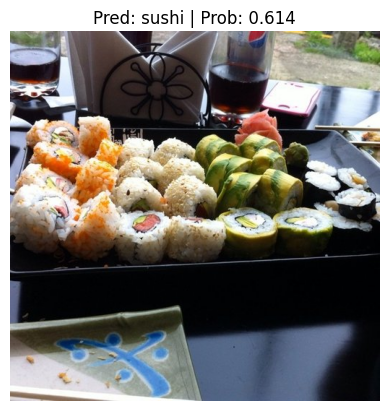

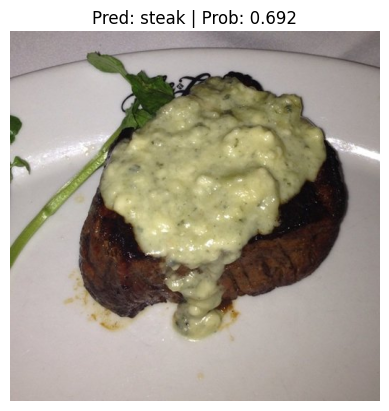

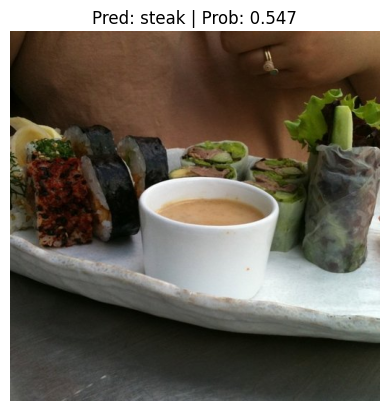

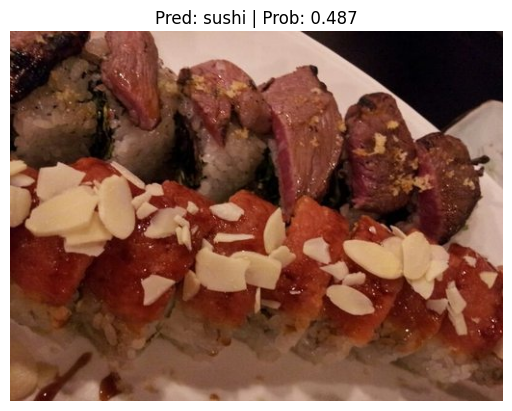

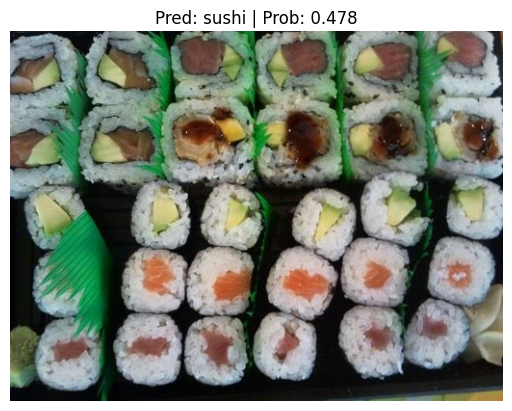

In [ ]:
from going_modular.going_modular import predictions
plt.figure(figsize=(3,3))
for img_path in list_of_random_test_images:
  predictions.pred_and_plot_image(model = model_0,
                                class_names = class_names,
                                image_path = img_path,
                                transform = simple_transform)

In [ ]:
len(test_dataloader)

3

In [ ]:
from tqdm.auto import tqdm

# make predictions on the entire dataset
test_preds = []
model_0.eval()
with torch.inference_mode():
  for X,y in tqdm(test_dataloader):
    X,y = X.to(device), y.to(device)

    test_logits = model_0(X)
    pred_prob = torch.softmax(test_logits, dim = 1)
    pred_label = torch.argmax(pred_prob, dim = 1)
    test_preds.append(pred_label)

# Concatinate the test preds and put them on the cpu
test_preds = torch.cat(test_preds).cpu()
test_preds


  0%|          | 0/3 [00:00<?, ?it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
        2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2,
        2, 2, 2])

In [ ]:
# Getting the truth label for all the test images
test_truth = torch.cat([y for X,y in test_dataloader])
test_truth

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2])

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

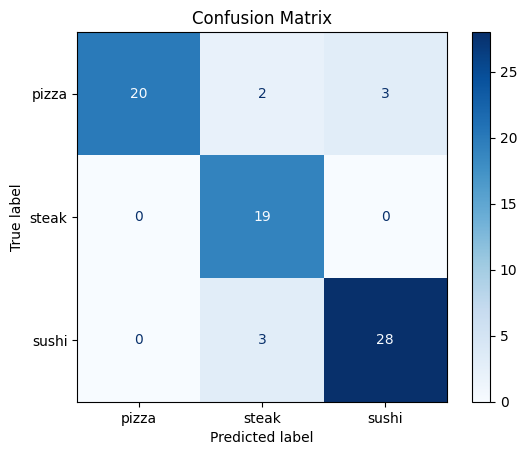

In [ ]:
cm = confusion_matrix(test_truth, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

## 2. Get the "most wrong" of the predictions on the test dataset and plot the 5 "most wrong" images. You can do this by:
* Predicting across all of the test dataset, storing the labels and predicted probabilities.
* Sort the predictions by *wrong prediction* and then *descending predicted probabilities*, this will give you the wrong predictions with the *highest* prediction probabilities, in other words, the "most wrong".
* Plot the top 5 "most wrong" images, why do you think the model got these wrong?

You'll want to:
* Create a DataFrame with sample, label, prediction, pred prob
* Sort DataFrame by correct (does label == prediction)
* Sort DataFrame by pred prob (descending)
* Plot the top 5 "most wrong" image predictions

In [ ]:
# Get all the data paths
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_labels = [path.parent.stem for path in test_data_paths]

# Create a function to return a list of dictionary with sample, label, prediction, pred prob
def pred_and_store(test_paths, model, transform, class_names, device):
  test_pred_list = []
  for path in test_paths:
    # Create an empty dictionary to store the info for each image
    pred_dict = {}

    # Get sample path
    pred_dict['image_path'] = path

    # Get the class name
    pred_dict['class_name'] = path.parent.stem

    # Get prediction and prediction probability
    from PIL import Image
    img = Image.open(path)
    transformed_image = transform(img).unsqueeze(dim = 0) # Transform the image and add batch dimmension
    y_logits = model(transformed_image.to(device))
    y_prob = torch.softmax(y_logits, dim = 1)
    pred_label = torch.argmax(y_prob, dim = 1)
    pred_class = class_names[pred_label.cpu()]

    # make sure the things in the dictionary are back on the cpu
    pred_dict['pred_prob'] = y_prob.unsqueeze(0).max().cpu().item()
    pred_dict['pred_class'] = pred_class

    pred_dict['correct'] = pred_class == path.parent.stem

    # Add the dictionary to the list
    test_pred_list.append(pred_dict)

  return test_pred_list

test_pred_list = pred_and_store(test_data_paths, model_0, simple_transform, class_names, device)
test_pred_list[:5]

[{'image_path': PosixPath('data/pizza_steak_sushi/test/pizza/416067.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.7701395750045776,
  'pred_class': 'pizza',
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/pizza/3092704.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.47425755858421326,
  'pred_class': 'pizza',
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/pizza/714866.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.6159310340881348,
  'pred_class': 'pizza',
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/pizza/2218680.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.3840886056423187,
  'pred_class': 'steak',
  'correct': False},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/pizza/1152100.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.7349491119384766,
  'pred_class': 'pizza',
  'correct': True}]

In [ ]:
# Turn the test_pred_dict intp a DataFrame
import pandas as pd
test_pred_df = pd.DataFrame(test_pred_list)
top_5_most_wrong = test_pred_df.sort_values(by = ["correct", "pred_prob"], ascending=[True, False]).head()
top_5_most_wrong

image_path class_name  pred_prob  \
63   data/pizza_steak_sushi/test/sushi/684266.jpg      sushi   0.546966   
44  data/pizza_steak_sushi/test/sushi/1172255.jpg      sushi   0.449595   
19   data/pizza_steak_sushi/test/pizza/971934.jpg      pizza   0.444701   
14  data/pizza_steak_sushi/test/pizza/2508636.jpg      pizza   0.435138   
15   data/pizza_steak_sushi/test/pizza/309892.jpg      pizza   0.426874   

   pred_class  correct  
63      steak    False  
44      steak    False  
19      sushi    False  
14      sushi    False  
15      sushi    False

<Figure size 100x200 with 0 Axes>

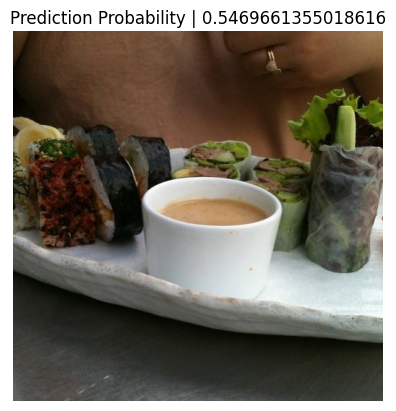

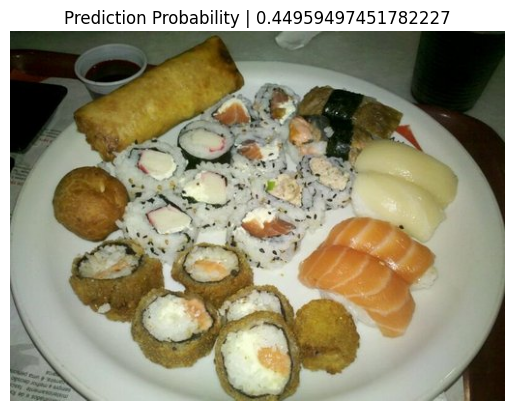

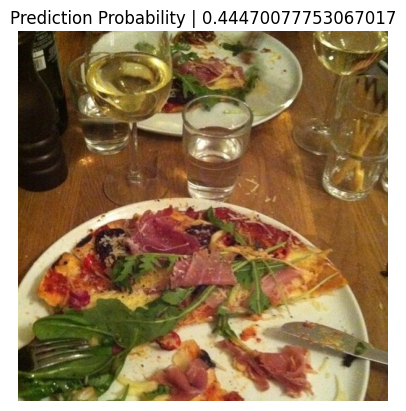

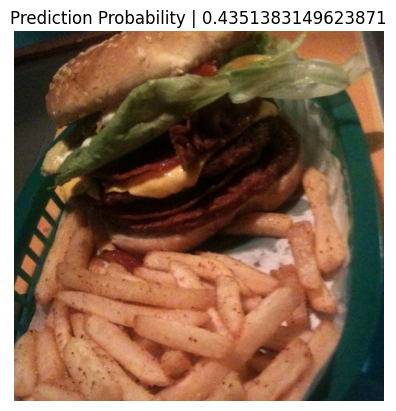

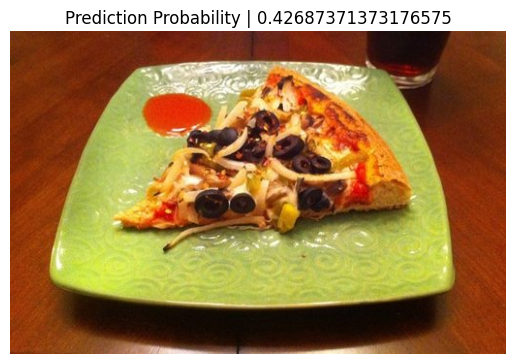

In [ ]:
# Plot the given predictions
from PIL import Image
plt.figure(figsize = (1,2))
for pred,row in top_5_most_wrong.iterrows():
  img = Image.open(str(row['image_path']))
  plt.figure()
  plt.imshow(img)
  plt.title(f"Prediction Probability | {row['pred_prob']}")
  plt.axis(False)

## 3. Predict on your own image of pizza/steak/sushi - how does the model go? What happens if you predict on an image that isn't pizza/steak/sushi?
* Here you can get an image from a website like http://www.unsplash.com to try it out or you can upload your own.

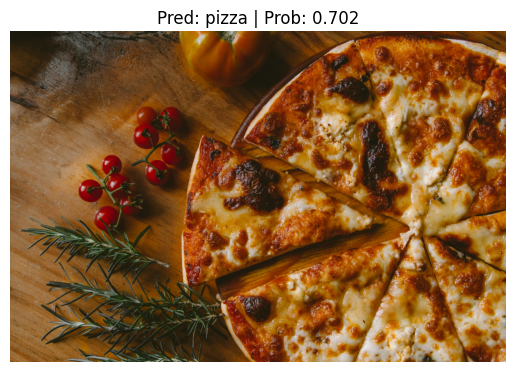

In [ ]:
# TODO: Get an image of pizza/steak/sushi
import requests
request = requests.get("https://images.unsplash.com/photo-1513104890138-7c749659a591?q=80&w=2070&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D")
with open("TestImage1.jpg", "wb") as f:
  f.write(request.content)

test_img_path = Path("TestImage1.jpg")
predictions.pred_and_plot_image(model = model_0,
                                class_names = class_names,
                                image_path = test_img_path,
                                transform = simple_transform)

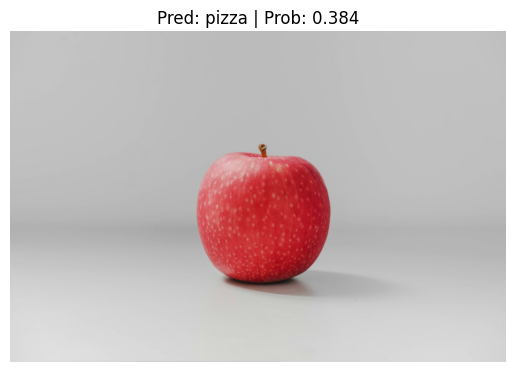

In [ ]:
# TODO: Get an image of not pizza/steak/sushi
import requests
request = requests.get("https://images.unsplash.com/photo-1568702846914-96b305d2aaeb?q=80&w=2070&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D")
with open("TestImage2.jpg", "wb") as f:
  f.write(request.content)

test_img_path = Path("TestImage2.jpg")
predictions.pred_and_plot_image(model = model_0,
                                class_names = class_names,
                                image_path = test_img_path,
                                transform = simple_transform)

## 4. Train the model from section 4  in notebook 06 part 3 for longer (10 epochs should do), what happens to the performance?

* See the model in notebook 06 part 3 for reference: https://www.learnpytorch.io/06_pytorch_transfer_learning/#3-getting-a-pretrained-model

In [ ]:
# TODO: Recreate a new model
weights1 = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model_1 = torchvision.models.efficientnet_b0(weights=weights1).to(device)
# model_1

# Freeze all the base layers in the features section of the model (the feature extractor) by setting requires_grad = Flase
for params in model_1.features.parameters():
  params.requires_grad = False

torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of the class_names
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model_1.classifier = nn.Sequential(
    torch.nn.Dropout(p = 0.2, inplace = True),
    torch.nn.Linear(in_features= 1280, out_features=output_shape, bias=True)
)

In [ ]:
# Define the loss function and the optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_1.parameters(), lr = 0.001)

In [ ]:
# Set the loss function
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the result
model_1_results = engine.train(model = model_1,
                               train_dataloader = train_dataloader,
                               test_dataloader = test_dataloader,
                               optimizer = optimizer,
                               loss_fn = loss_fn,
                               epochs = 10,
                               device = device)
end_time = timer()
print(f"[INFO] Total training time: {end_time - start_time:.2f}")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0895 | train_acc: 0.4414 | test_loss: 0.9202 | test_acc: 0.5085
Epoch: 2 | train_loss: 0.8682 | train_acc: 0.7734 | test_loss: 0.8022 | test_acc: 0.7434
Epoch: 3 | train_loss: 0.7771 | train_acc: 0.7812 | test_loss: 0.7399 | test_acc: 0.7737
Epoch: 4 | train_loss: 0.7249 | train_acc: 0.7422 | test_loss: 0.6472 | test_acc: 0.8864
Epoch: 5 | train_loss: 0.6445 | train_acc: 0.7812 | test_loss: 0.6244 | test_acc: 0.8968
Epoch: 6 | train_loss: 0.6022 | train_acc: 0.7656 | test_loss: 0.5565 | test_acc: 0.8864
Epoch: 7 | train_loss: 0.5411 | train_acc: 0.9258 | test_loss: 0.5279 | test_acc: 0.9176
Epoch: 8 | train_loss: 0.5493 | train_acc: 0.8086 | test_loss: 0.5291 | test_acc: 0.9176
Epoch: 9 | train_loss: 0.5725 | train_acc: 0.7969 | test_loss: 0.4947 | test_acc: 0.9072
Epoch: 10 | train_loss: 0.5219 | train_acc: 0.7969 | test_loss: 0.4207 | test_acc: 0.8655
[INFO] Total training time: 16.72


## 5. Train the model from section 4 above with more data, say 20% of the images from Food101 of Pizza, Steak and Sushi images.
* You can find the [20% Pizza, Steak, Sushi dataset](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip) on the course GitHub. It was created with the notebook [`extras/04_custom_data_creation.ipynb`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb).


### Get 20% data

In [ ]:
import os
import requests
import zipfile

from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"
image_data_zip_path = "pizza_steak_sushi_20_percent.zip"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / image_data_zip_path, "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / image_data_zip_path, "r") as zip_ref:
        print("Unzipping pizza, steak, sushi 20% data...")
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / image_data_zip_path)

# Setup Dirs
train_dir_20_percent = image_path / "train"
test_dir_20_percent = image_path / "test"

train_dir_20_percent, test_dir_20_percent

Did not find data/pizza_steak_sushi_20_percent directory, creating one...
Unzipping pizza, steak, sushi 20% data...


(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

### Create DataLoaders

In [ ]:
# Create a transforms pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [ ]:
# Create training and testing DataLoader's as well as get a list of class names
train_dataloader_20_percent, test_dataloader_20_percent, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                                                                     test_dir=test_dir_20_percent,
                                                                                                     transform=simple_transform, # resize, convert images to between 0 & 1 and normalize them
                                                                                                     batch_size=32) # set mini-batch size to 32

train_dataloader_20_percent, test_dataloader_20_percent, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7ff2c3f3c510>,
 ['pizza', 'steak', 'sushi'])

### Get a pretrained model

In [ ]:
# TODO
weights2 = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model_2 = torchvision.models.efficientnet_b0(weights = weights2).to(device)

for params in model_2.features.parameters():
  params.requires_grad = False

model_2.classifier = nn.Sequential(
    nn.Dropout(p = 0.2, inplace = True),
    nn.Linear(in_features=1280, out_features=len(class_names), bias = True)
)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_2.parameters(), lr = 0.001)


### Train a model with 20% of the data

In [ ]:
# TODO
torch.manual_seed(42)
torch.cuda.manual_seed(42)

results_model_2 = engine.train(model=model_2,
             train_dataloader = train_dataloader_20_percent,
             test_dataloader = test_dataloader_20_percent,
             optimizer = optimizer,
             loss_fn = loss_fn,
             epochs = 10,
             device = device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9901 | train_acc: 0.5333 | test_loss: 0.6995 | test_acc: 0.8761
Epoch: 2 | train_loss: 0.6953 | train_acc: 0.8375 | test_loss: 0.5377 | test_acc: 0.9097
Epoch: 3 | train_loss: 0.5778 | train_acc: 0.8729 | test_loss: 0.4563 | test_acc: 0.9034
Epoch: 4 | train_loss: 0.4488 | train_acc: 0.8833 | test_loss: 0.4128 | test_acc: 0.9062
Epoch: 5 | train_loss: 0.4435 | train_acc: 0.8917 | test_loss: 0.3777 | test_acc: 0.9222
Epoch: 6 | train_loss: 0.4264 | train_acc: 0.8354 | test_loss: 0.3571 | test_acc: 0.9222
Epoch: 7 | train_loss: 0.4259 | train_acc: 0.8396 | test_loss: 0.3131 | test_acc: 0.9097
Epoch: 8 | train_loss: 0.4000 | train_acc: 0.8500 | test_loss: 0.3220 | test_acc: 0.9068
Epoch: 9 | train_loss: 0.3183 | train_acc: 0.8958 | test_loss: 0.3053 | test_acc: 0.9131
Epoch: 10 | train_loss: 0.3379 | train_acc: 0.9104 | test_loss: 0.2710 | test_acc: 0.9347


## 6. Try a different model from [`torchvision.models`](https://pytorch.org/vision/stable/models.html) on the Pizza, Steak, Sushi data, how does this model perform?
* You'll have to change the size of the classifier layer to suit our problem.
* You may want to try an EfficientNet with a higher number than our B0, perhaps `torchvision.models.efficientnet_b2()`?
  * **Note:** Depending on the model you use you will have to prepare/transform the data in a certain way.

In [ ]:
# TODO
weights3 = torchvision.models.EfficientNet_B2_Weights.DEFAULT
model_3 = torchvision.models.efficientnet_b2(weights=weights3).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 164MB/s]


In [ ]:
auto_transform = weights3.transforms()
auto_transform

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [ ]:
# Create training and testing DataLoader's as well as get a list of class names
train_dataloader_20_percent, test_dataloader_20_percent, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                                                                     test_dir=test_dir_20_percent,
                                                                                                     transform=auto_transform, # resize, convert images to between 0 & 1 and normalize them
                                                                                                     batch_size=32) # set mini-batch size to 32

train_dataloader_20_percent, test_dataloader_20_percent, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7ff3620665d0>,
 ['pizza', 'steak', 'sushi'])

In [ ]:
for params in model_3.features.parameters():
  params.requires_grad = False

In [ ]:
model_3.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [ ]:
model_3.classifier = nn.Sequential(
    nn.Dropout(p = 0.3, inplace = True),
    nn.Linear(in_features=1408, out_features=len(class_names))
)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_3.parameters(), lr = 0.001)

In [ ]:
model_3_results = engine.train(model = model_3,
             train_dataloader = train_dataloader_20_percent,
             test_dataloader = test_dataloader_20_percent,
             optimizer = optimizer,
             loss_fn = loss_fn,
             epochs = 10,
             device = device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9650 | train_acc: 0.5792 | test_loss: 0.7141 | test_acc: 0.9313
Epoch: 2 | train_loss: 0.6725 | train_acc: 0.8562 | test_loss: 0.5653 | test_acc: 0.9597
Epoch: 3 | train_loss: 0.5342 | train_acc: 0.8833 | test_loss: 0.4644 | test_acc: 0.9500
Epoch: 4 | train_loss: 0.4587 | train_acc: 0.9021 | test_loss: 0.4046 | test_acc: 0.9563
Epoch: 5 | train_loss: 0.4355 | train_acc: 0.8896 | test_loss: 0.3867 | test_acc: 0.9534
Epoch: 6 | train_loss: 0.3629 | train_acc: 0.9021 | test_loss: 0.3453 | test_acc: 0.9381
Epoch: 7 | train_loss: 0.3406 | train_acc: 0.9333 | test_loss: 0.3178 | test_acc: 0.9318
Epoch: 8 | train_loss: 0.3223 | train_acc: 0.9083 | test_loss: 0.3141 | test_acc: 0.9563
Epoch: 9 | train_loss: 0.3749 | train_acc: 0.8938 | test_loss: 0.2836 | test_acc: 0.9625
Epoch: 10 | train_loss: 0.3403 | train_acc: 0.8896 | test_loss: 0.2749 | test_acc: 0.9381
